## Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## Data Preparation

### Load Data

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
Y_train = train['label']
X_train = train.drop(labels=['label'], axis=1)

del train

In [7]:
Y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

### Normalization

In [8]:
X_train = X_train / 255.0
X_test = test / 255.0

### Reshape

In [9]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

### Label Encoding

In [10]:
Y_train = to_categorical(Y_train, num_classes=10)

### Split data

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

### Preview Data

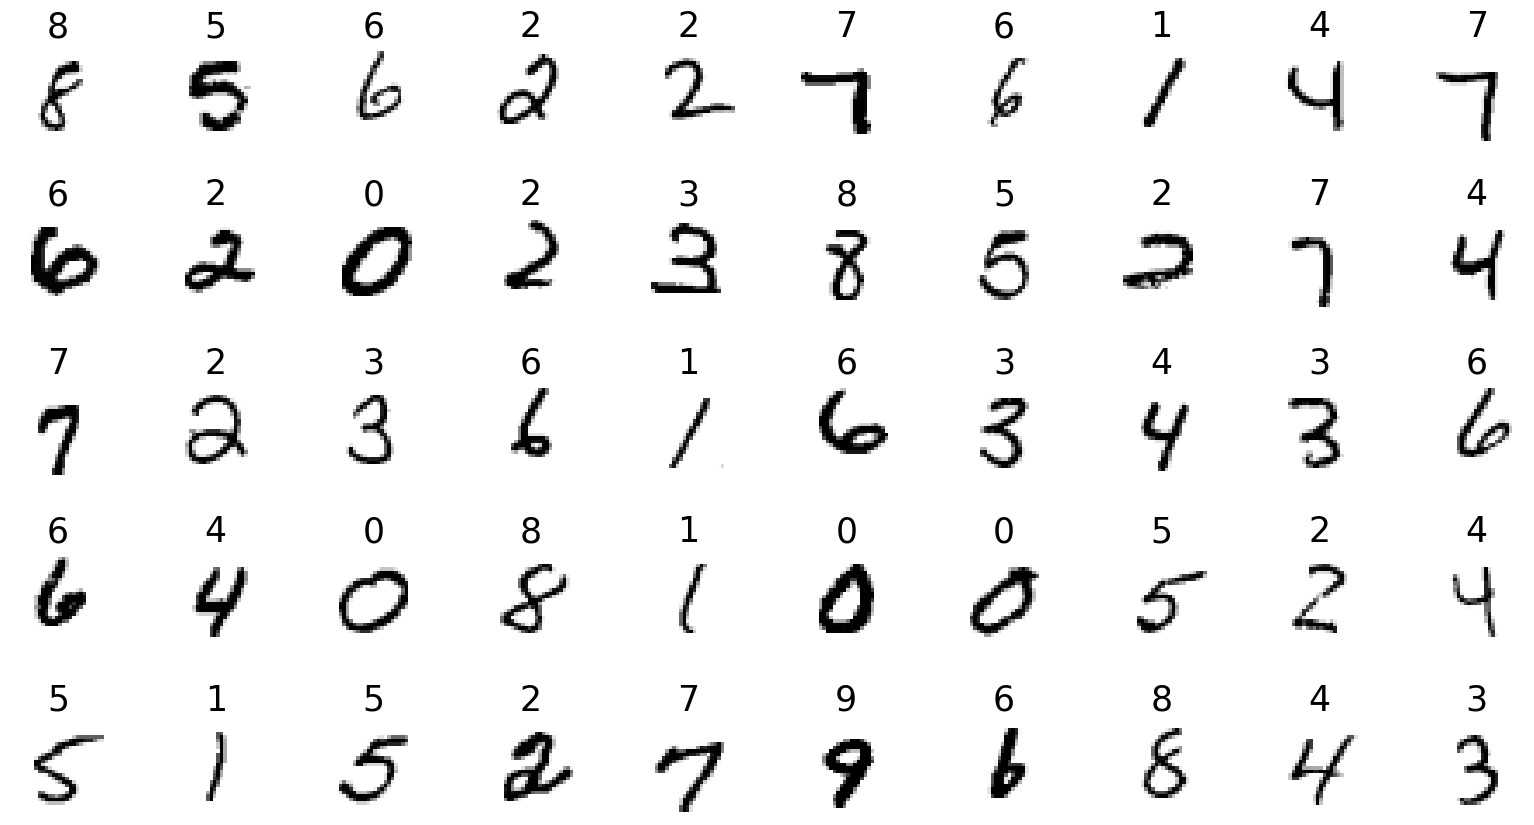

In [12]:
plt.figure(figsize=(20, 10))

for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)), cmap=plt.cm.binary)
    plt.title(np.argmax(Y_train[i]), fontsize=25)
    plt.axis('off')

plt.subplots_adjust(hspace=0.75)
plt.show()

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X_train)

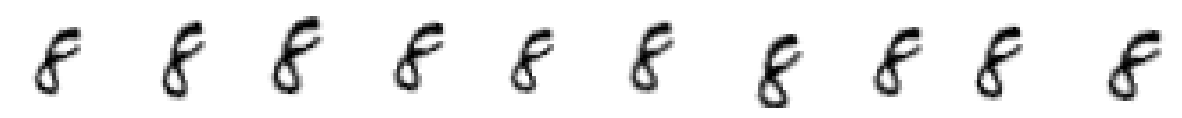

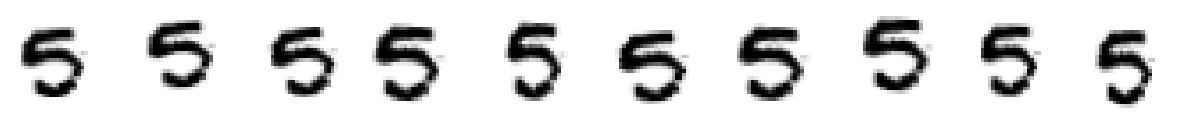

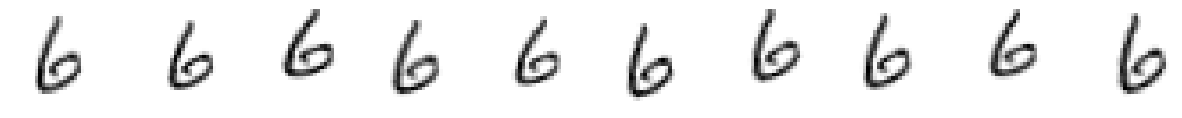

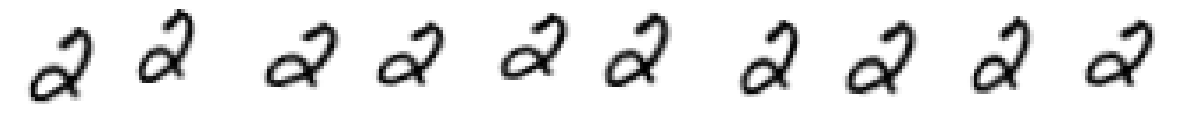

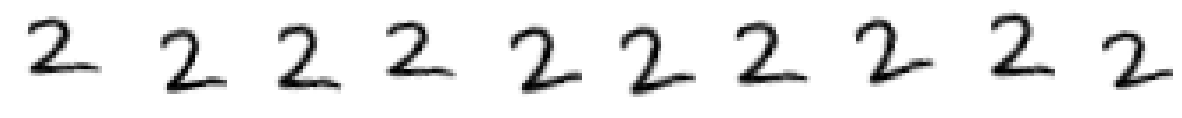

In [14]:
for k in range(5):
    sample_image = X_train[k].reshape((1, 28, 28, 1))
    augmented_images = datagen.flow(sample_image, batch_size=1)
    
    plt.figure(figsize=(15, 5))
    
    for i in range(10):
        augmented_image = next(augmented_images)[0]
        plt.subplot(1, 10, i + 1)
        plt.imshow(augmented_image.reshape(28, 28), cmap=plt.cm.binary)
        plt.axis('off')

    plt.show()

## Model

### Define the Model

In [15]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation ='relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

c:\Users\KISEKI\anaconda3\envs\tensor_flow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the Model

In [16]:
model.compile(optimizer="adam", loss = "categorical_crossentropy", metrics=["accuracy"])

### Fit the Model

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [18]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=64), epochs=30, validation_data=(X_val, Y_val), verbose = 2, steps_per_epoch=X_train.shape[0] // 64, callbacks=[learning_rate_reduction])

Epoch 1/30


c:\Users\KISEKI\anaconda3\envs\tensor_flow\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 - 36s - 60ms/step - accuracy: 0.8698 - loss: 0.4037 - val_accuracy: 0.9748 - val_loss: 0.0892 - learning_rate: 0.0010
Epoch 2/30


c:\Users\KISEKI\anaconda3\envs\tensor_flow\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


590/590 - 1s - 2ms/step - accuracy: 0.9375 - loss: 0.1584 - val_accuracy: 0.9769 - val_loss: 0.0837 - learning_rate: 0.0010
Epoch 3/30
590/590 - 33s - 56ms/step - accuracy: 0.9601 - loss: 0.1404 - val_accuracy: 0.9876 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 4/30
590/590 - 1s - 2ms/step - accuracy: 0.9531 - loss: 0.0974 - val_accuracy: 0.9874 - val_loss: 0.0440 - learning_rate: 0.0010
Epoch 5/30
590/590 - 33s - 55ms/step - accuracy: 0.9695 - loss: 0.0997 - val_accuracy: 0.9874 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 6/30

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
590/590 - 1s - 2ms/step - accuracy: 0.9844 - loss: 0.0414 - val_accuracy: 0.9860 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 7/30
590/590 - 32s - 55ms/step - accuracy: 0.9790 - loss: 0.0710 - val_accuracy: 0.9907 - val_loss: 0.0285 - learning_rate: 5.0000e-04
Epoch 8/30
590/590 - 1s - 2ms/step - accuracy: 0.9844 - loss: 0.0275 - val_accuracy: 0.9914 - val_loss: 0.0283 - l

## Evaluate the Model

### Training and validation curves

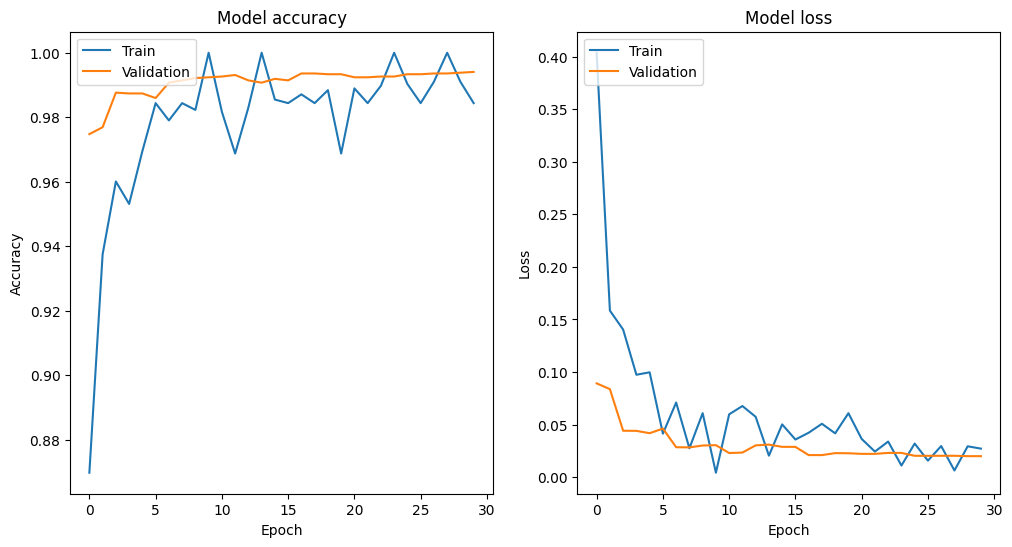

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Predict

In [20]:
X_test = test.values.reshape(-1, 28, 28, 1)

results = model.predict(X_test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")

[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]

In [21]:
submission = pd.concat([pd.Series(range(1, 28001), name = "ImageId"), results], axis = 1)
submission.to_csv("cnn_result.csv", index=False)

### Save the Model

In [22]:
model.save('cnn_model.keras')